# **Проект "Телеком"**

## Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

**Описание полей данных**

- BeginDate – дата начала пользования услугами,
- EndDate – дата окончания пользования услугами,
- Type – тип договора: ежемесячный, годовой и т.д,
- PaperlessBilling – факт выставления счёта на электронную почту,
- PaymentMethod – способ оплаты,
- MonthlyCharges – ежемесячные траты на услуги,
- TotalCharges – всего потрачено денег на услуги,
- Dependents – наличие иждивенцев,
- Senior Citizen – наличие пенсионного статуса по возрасту,
- Partner – наличие супруга(и),
- MultipleLines – наличие возможности ведения параллельных линий во время звонка.

Информация о договорах актуальна на 1 февраля 2020.

### Данные

[final_provider.zip](https://s3-us-west-2.amazonaws.com/secure.notion-static.com/ac39c23b-718e-4cd6-bdaa-85b3a127a457/final_provider.zip)

Данные также находятся в папке `/datasets/final_provider/`.

## Задачи проекта

У нас новый проект, связанный с анализом оттока клиентов, заказчик - оператор связи. Нам предстоит построить прототип модели машинного обучения, которая поможет предсказать уход клиента. Заказчик предоставил нам данные и ждет классного результата, как и всегда.

Наш проект можно поделить на четыре части:
1. составление плана работы и исследование данных (нужно разобраться с имеющимися данными, произвести первичный анализ, обозначить дальнейшие шаги);
2. уточнение задачи;
3. предобработка данных и разработка модели;
4. составление отчёта.

По условиям проекта нам нужно принять RANDOM_STATE = 311022.

Качество модели будем оценивать метрикой AUC-ROC. Нам нужно достичь ее значения 0.85 и больше.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from catboost import cv, Pool, CatBoostClassifier
from catboost.utils import get_roc_curve
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import plot_roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn import linear_model, decomposition
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
try:
    contract = pd.read_csv('/datasets/final_provider/contract.csv', index_col=['customerID'],
                           parse_dates=['BeginDate', 'EndDate'])
    personal = pd.read_csv('/datasets/final_provider/personal.csv', index_col=['customerID'])
    internet = pd.read_csv('/datasets/final_provider/internet.csv', index_col=['customerID'])
    phone = pd.read_csv('/datasets/final_provider/phone.csv', index_col=['customerID'])
except:
    contract = pd.read_csv('contract.csv', index_col=['customerID'],
                           parse_dates=['BeginDate', 'EndDate'])
    personal = pd.read_csv('personal.csv', index_col=['customerID'])
    internet = pd.read_csv('internet.csv', index_col=['customerID'])
    phone = pd.read_csv('phone.csv', index_col=['customerID'])

In [3]:
def func(data):
    display(data.head(), data.info(), data.describe(include='all'))

In [4]:
func(contract)

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB


C:\Users\Vera\AppData\Local\Temp/ipykernel_4768/692917948.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(data.head(), data.info(), data.describe(include='all'))


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


None

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043.000000,7043
unique,77,5,3,2,4,NaN,6531
top,2014-02-01 00:00:00,No,Month-to-month,Yes,Electronic check,NaN,
freq,366,5174,3875,4171,2365,NaN,11
first,2013-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,35.500000,NaN


In [5]:
func(personal)

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


None

,gender,SeniorCitizen,Partner,Dependents
count,7043,7043.000000,7043,7043
unique,2,NaN,2,2
top,Male,NaN,No,No
freq,3555,NaN,3641,4933
mean,NaN,0.162147,NaN,NaN
std,NaN,0.368612,NaN,NaN
min,NaN,0.000000,NaN,NaN
25%,NaN,0.000000,NaN,NaN
50%,NaN,0.000000,NaN,NaN
75%,NaN,0.000000,NaN,NaN


In [6]:
func(internet)

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


None

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785


In [7]:
func(phone)

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


None

,MultipleLines
count,6361
unique,2
top,No
freq,3390


### Вывод по разделу

Исходные данные нам представлены в 4 таблицах:

- contract состоит из 7043 объектов.
- personal состоит из 7043 объектов.
- internet состоит из 5517 объектов.
- phone состоит из 6361 объектов.

Хорошо, что в самих таблицах нет пропусков. Однако количество объектов в данных разное, поэтому в зависимости от метода объединения таблиц, пропуски могут появиться при объединении данных или в противном случае часть данных потеряется.

Столбцы `EndDate` и `TotalCharges` в таблице `contract` имеют строковый тип данных, их нужно будет обработать. TotalCharges привести к вещественному типу, а на основании EndDate создать новый столбец с целевым признаком (если дата есть - клиент ушел - присвоим значение 1, если даты нет - клиент действующий - присвоим значение 0).

В остальных таблицах типы значений в столбцах не требуют корректировок.

## Примерный план решения задачи

1. Предобработка данных: проверка дубликатов, изменение типов значений в столбцах, поиск и обработка аномальных значений

2. Объединение таблиц: выбор правильного метода объединения, обработка пропусков при их появлении

3. Выделение целевого признака, анализ остальных признаков на их важность, внесение изменений или удаление признаков после проведенного анализа данных

4. Выделение обучающей и тестовой выборок. Создание нескольких моделей и подбор для них лучших гиперпараметров

5. Тестирование лучшей модели на тестовой выборке

# Предобработка данных

## Работа с дубликатами

In [8]:
print('Количество полных дубликатов в исходных данных:', 'contract -', contract.duplicated().sum(),
      ', personal -', personal.duplicated().sum(), ', internet -', internet.duplicated().sum(),
      ', phone -', phone.duplicated().sum())

Количество полных дубликатов в исходных данных: contract - 45 , personal - 7027 , internet - 5389 , phone - 6359


В датафреймах `personal`, `internet`, `phone` много полных дубликатов, и это нормально, потому что одни и те же тарифы могут повторяться у разных клиентов. А вот датафрейм `contract` посмотрим подробнее.

In [9]:
contract[contract.duplicated()]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7617-EYGLW,2020-01-01,No,Month-to-month,No,Electronic check,19.45,19.45
4291-HPAXL,2020-01-01,No,Month-to-month,No,Mailed check,19.85,19.85
8605-ITULD,2020-01-01,No,Month-to-month,No,Mailed check,19.55,19.55
2812-SFXMJ,2020-01-01,No,Month-to-month,No,Mailed check,20.05,20.05
3247-MHJKM,2020-01-01,No,Month-to-month,No,Mailed check,20.20,20.2
1942-OQFRW,2020-01-01,No,Month-to-month,No,Electronic check,44.00,44
5996-DAOQL,2020-01-01,No,Month-to-month,Yes,Mailed check,20.45,20.45
0415-MOSGF,2019-09-01,2019-10-01 00:00:00,Month-to-month,No,Mailed check,44.40,44.4
2668-TZSPS,2020-01-01,No,Month-to-month,No,Mailed check,20.45,20.45


Тут тоже никаких критичных дубликатов не обнаруживаем, полные дубликаты встречаются у клиентов, которые только подключились месяц назад, а также у клиентов, которые всего лишь 1 месяц пользовались услугами компании. соотвественно, и у тех, и у других, данные представлены за 1 месяц, тарифы совпадают и расходы аналогично полностью идентичны.

Таким образом, полные дубликаты не требуют дополнительной предобработки.

## Работа с типами значений в столбцах

In [10]:
sorted(contract['TotalCharges'].unique())

[' ',
 '100.2',
 '100.25',
 '100.35',
 '100.4',
 '100.8',
 '100.9',
 '1001.2',
 '1001.5',
 '1003.05',
 '1004.35',
 '1004.5',
 '1004.75',
 '1005.7',
 '1006.9',
 '1007.8',
 '1007.9',
 '1008.55',
 '1008.7',
 '1009.25',
 '101.1',
 '101.45',
 '101.65',
 '101.9',
 '1010',
 '1011.05',
 '1011.5',
 '1011.8',
 '1012.4',
 '1013.05',
 '1013.2',
 '1013.35',
 '1013.6',
 '1014.25',
 '1016.7',
 '1017.35',
 '102.45',
 '102.5',
 '102.75',
 '1020.2',
 '1020.75',
 '1021.55',
 '1021.75',
 '1021.8',
 '1022.5',
 '1022.6',
 '1022.95',
 '1023.75',
 '1023.85',
 '1023.9',
 '1023.95',
 '1024',
 '1024.65',
 '1024.7',
 '1025.05',
 '1025.15',
 '1025.95',
 '1026.35',
 '1027.25',
 '1028.75',
 '1028.9',
 '1029.35',
 '1029.75',
 '1029.8',
 '103.7',
 '1031.1',
 '1031.4',
 '1031.7',
 '1032',
 '1032.05',
 '1033',
 '1033.9',
 '1033.95',
 '1035.5',
 '1035.7',
 '1036',
 '1036.75',
 '1037.75',
 '1039.45',
 '104.2',
 '104.3',
 '1041.8',
 '1042.65',
 '1043.3',
 '1043.35',
 '1043.4',
 '1043.8',
 '1045.25',
 '1046.1',
 '1046.2',
 

In [11]:
contract.query('TotalCharges == " "')

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,


В столбце 'TotalCharges' пробелами обозначены данные у клиентов, которые только подключились с 01.02.2020, поэтому у них еще нет расходов, поэтому сначала заменим ячейки с пробелами значениями 0, затем переведем значения столбца в вещественный формат.

In [12]:
contract.loc[contract['TotalCharges'] == ' ', 'TotalCharges'] = 0
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='raise')

In [13]:
display(contract.head()), contract.info()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 440.2+ KB


(None, None)

Ранее с помощью метода describe мы увидели, что:

- в датафрейме **personal** форматы значений менять не требуется, а также в нем нет посторонних значений в столбцах с категориальными признаками

- в датафрейме **internet** аналогично формат значений удобный и нет аномальных значений признаков. Однако стоит обратить внимание, что объектов в данной таблице меньше, чем в предыдущих. Получается, что не все наши уникальные клиенты пользуются услугами интернета. Это нужно будет учесть при объединении таблиц, то есть значения пропусков нам нужно будет заменить на no_used.

- Аналогично в датафрейме **phone**: формат менять не требуется, аномальных значений нет, объектов меньше в сравнении с первым датафреймом, значит не все клиенты пользуются телефонией, поэтому пропуски при объединении таблиц заменим на no_used.

## Работа с аномальными значениями (поиск и обработка при необходимости)

In [14]:
def categorical_variables(data: pd.DataFrame, variables: list):
    count = len(variables)
    fig, axes = plt.subplots(1, count, figsize=(15, 5))
    if count>1:
        for ax, variable in zip(axes, variables):
            sns.countplot(data=data, x=variable, ax=ax).set_title(variable)
    else:
        sns.countplot(data=data, x=variables[0], ax=axes).set_title(variables[0])
    plt.show()

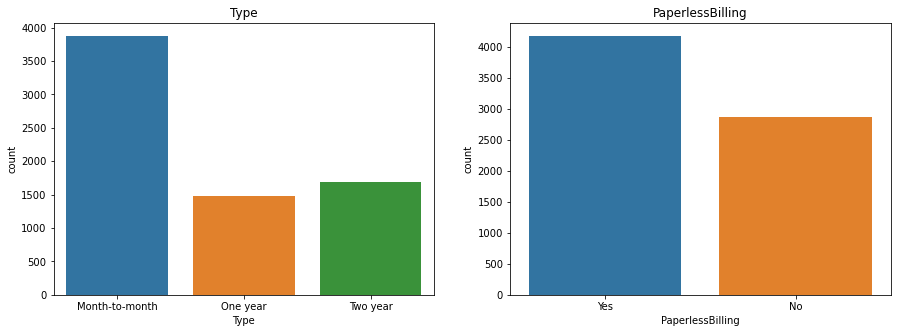

In [15]:
categorical_variables(contract, ['Type', 'PaperlessBilling'])

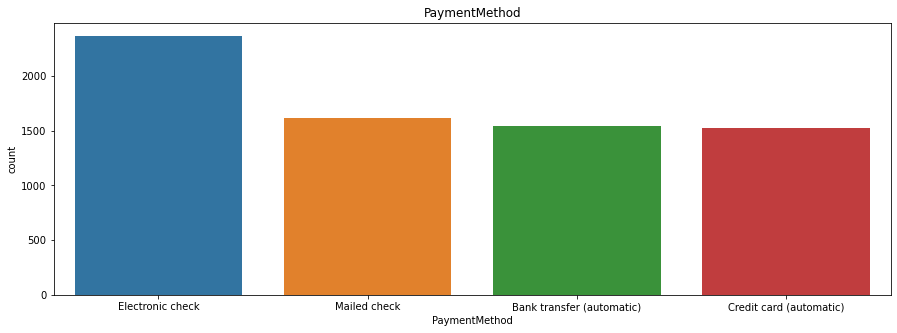

In [16]:
categorical_variables(contract, ['PaymentMethod'])

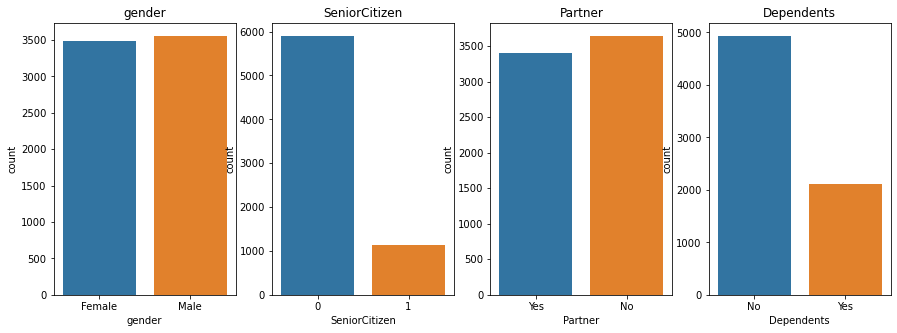

In [17]:
categorical_variables(personal, ['gender', 'SeniorCitizen', 'Partner', 'Dependents'])

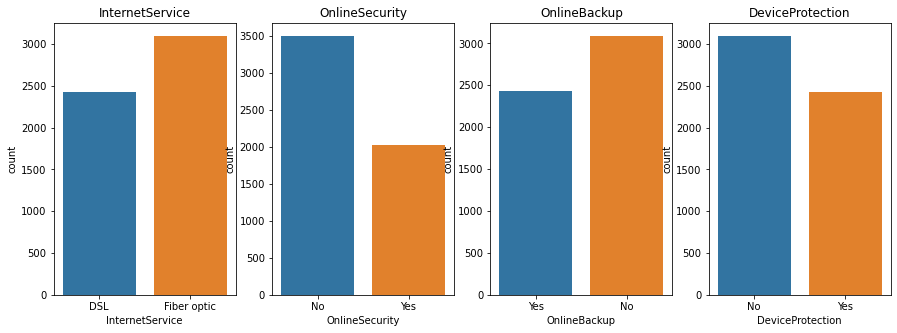

In [18]:
categorical_variables(internet, ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection'])

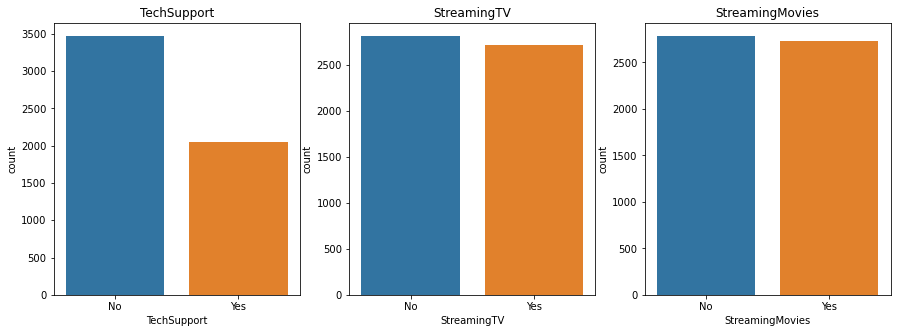

In [19]:
categorical_variables(internet, ['TechSupport', 'StreamingTV', 'StreamingMovies'])

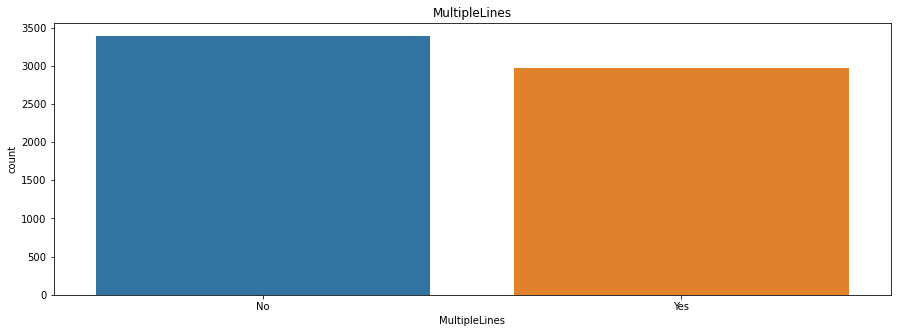

In [20]:
categorical_variables(phone, ['MultipleLines'])

Таким образом, оценив распределение признаков на графиках, можно отметить что аномальных значений нет, все признаки, кроме `наличие пенсионного статуса по возрасту` примерно распределены поровну. А вот пенсионеров оказалось значительно меньше, чем остальных клиентов, и это тоже нормально, значит компания не особо ориентирована на данных слой населения.

# Объединение таблиц

In [21]:
contract_all = contract.merge(personal, on='customerID', how='left'
                             ).merge(internet, on='customerID', how='left'
                                    ).merge(phone, on='customerID', how='left')

Объединение таблиц производим методом `left`, так как у нас разное количество объектов в датафреймах. Присоединяем три таблицы к таблице `contract`. Нам важно, чтобы никто из датафрейма `contract` не потерялся.

In [22]:
contract_all.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [23]:
contract_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   int64         
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   5517 non-null   object        
 12  OnlineSecurity    5517 non-null   object        
 13  OnlineBackup      5517 non-null   object        
 14  DeviceProtecti

Как мы решили ранее, пропуски после объединения таблиц заполним значениями `no_used`.

In [24]:
contract_all = contract_all.fillna('no_used')

# Работа с признаками

## Создание столбца с целевым признаком

In [25]:
contract_all['target'] = np.where((contract_all['EndDate'] == 'No'), 0, 1)

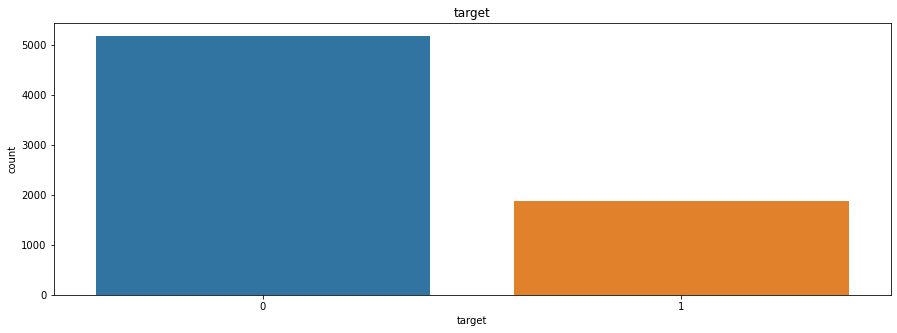

In [26]:
categorical_variables(contract_all, ['target'])

В нашей выборке ушедших клиентов в 3 раза меньше, чем оставшихся.

## Создание столбца с длительностью контракта (в днях)

In [27]:
contract_all.loc[contract_all['EndDate'] == 'No', 'EndDate'] = '2020-02-01'
contract_all['EndDate'] = pd.to_datetime(contract_all['EndDate'], errors='coerce')

In [28]:
contract_all['contract_duration'] = round((contract_all['EndDate'] - 
                                           contract_all['BeginDate'])
                                          /np.timedelta64(1, 'D')).astype(int)

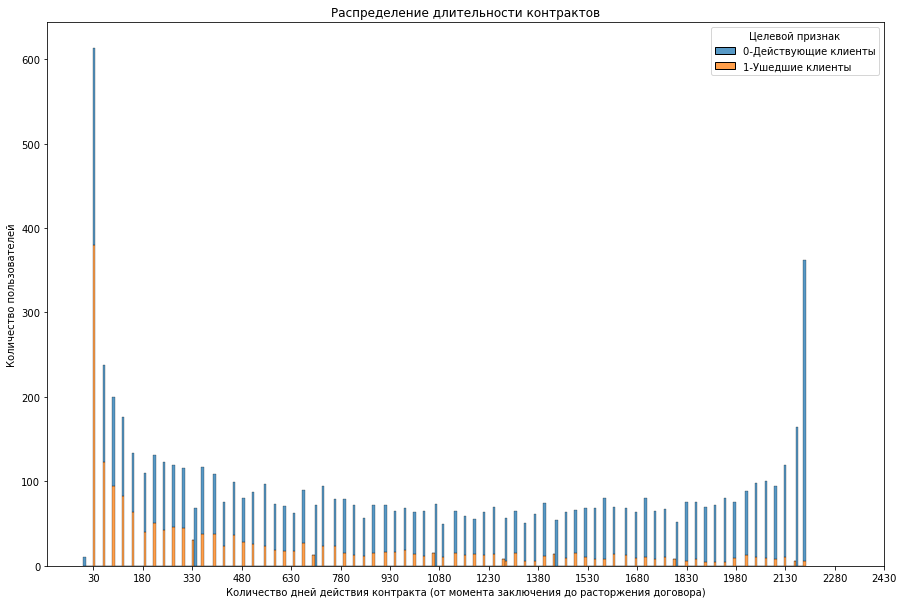

In [29]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot(data=contract_all,
            x='contract_duration',
            bins=300,
            hue='target',
            multiple='stack')

plt.title('Распределение длительности контрактов')
plt.xlabel('Количество дней действия контракта (от момента заключения до расторжения договора)')
plt.ylabel('Количество пользователей')
ax.set_xticks(np.arange(30, 2500, step=150))

legend = ax.get_legend()
handles = legend.legendHandles
legend.remove()
ax.legend(handles, ['0-Действующие клиенты', '1-Ушедшие клиенты'], title='Целевой признак')

plt.show()

Из графика видим, что максимальная доля ушедших клиентов приходится на пользователей с длительностью контракта 1 месяц. Чем больше клиент пользуется услугами компании, тем меньше среди них доля ушедших клиентов.

Пик в конце графика показывает нам тех пользователей, которые подключались в самом начале.

## Создание столбца на основании признака `MonthlyCharges`

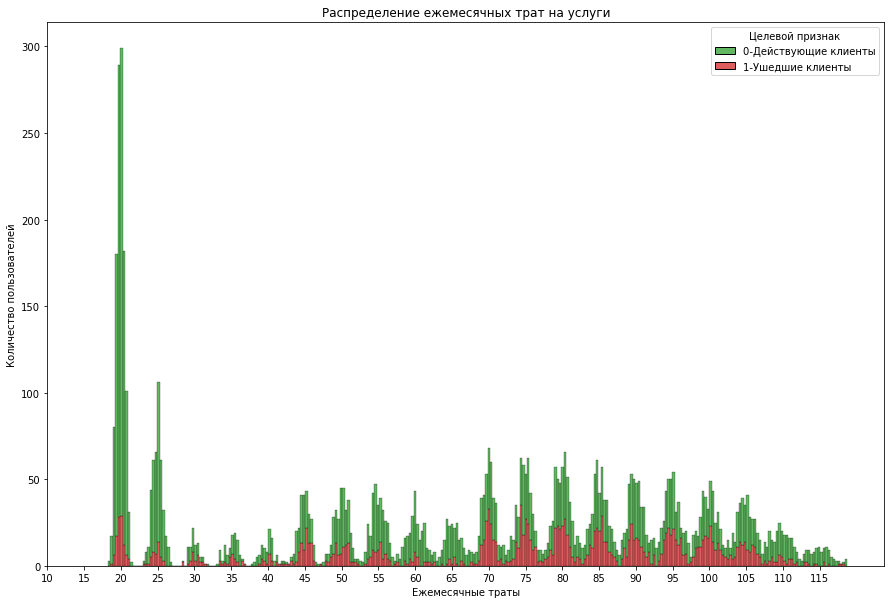

In [30]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot(data=contract_all,
            x='MonthlyCharges',
            bins=300,
            hue='target',
            ax=ax,
            palette=['tab:green', 'tab:red'],
            hue_order=[0,1],
            multiple='stack')

plt.title('Распределение ежемесячных трат на услуги')
plt.xlabel('Ежемесячные траты')
plt.ylabel('Количество пользователей')
ax.set_xticks(np.arange(10, 120, step=5))

legend = ax.get_legend()
handles = legend.legendHandles
legend.remove()
ax.legend(handles, ['0-Действующие клиенты', '1-Ушедшие клиенты'], title='Целевой признак')

plt.show()

Исходя из полученных графиков, мы видим 3 группы пользователей:

1. Особенно много ушедших клиентов, имеющих бОльшие ежемесячные расходы (от 68 усл.ед. до 107 усл.ед). Их доля среди клиентов с аналогичной суммой расходов составляет около 50%

2. Наименьшая доля ушедших клиентов среди пользователей с аналогичными расходами приходится на группу, у которой расходы составляют около 20 усл.ед.

3. Остальные пользователи (с расходами 27-67 и более 108 усл.ед.). Среди них доля ушедших клиентов колеблется.

Создадим новый столбец, где разделим клиентов на эти 3 группы.

In [31]:
contract_all.loc[(contract_all['MonthlyCharges']>=68) & (contract_all['MonthlyCharges']<=107), 'Group'] = 1

contract_all.loc[contract_all['MonthlyCharges']<=27, 'Group'] = 2

contract_all.loc[(contract_all['MonthlyCharges']>27) & (contract_all['MonthlyCharges']<68), 'Group'] = 3
contract_all.loc[(contract_all['MonthlyCharges']>107), 'Group'] = 3

In [32]:
contract_all.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,contract_duration,Group
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,...,No,Yes,No,No,No,No,no_used,0,31,3.0
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,0,No,...,Yes,No,Yes,No,No,No,No,0,1036,3.0
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,...,Yes,Yes,No,No,No,No,No,1,61,3.0
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,...,Yes,No,Yes,Yes,No,No,no_used,0,1371,3.0
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,...,No,No,No,No,No,No,No,1,61,1.0


## Анализ признака `TotalCharges`

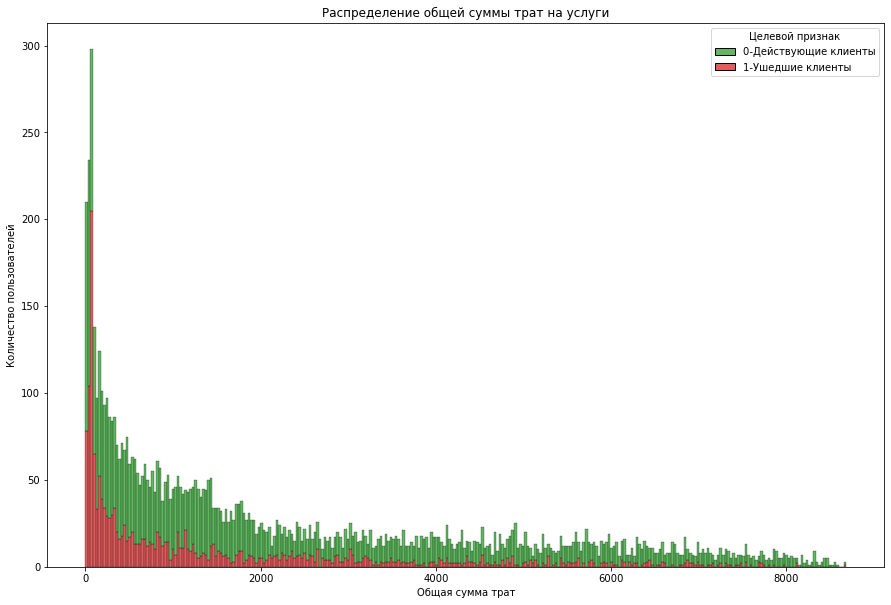

In [33]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot(data=contract_all,
            x='TotalCharges',
            bins=300,
            hue='target',
            palette=['tab:green', 'tab:red'],
            hue_order=[0,1],
            multiple='stack')

plt.title('Распределение общей суммы трат на услуги')
plt.xlabel('Общая сумма трат')
plt.ylabel('Количество пользователей')

legend = ax.get_legend()
handles = legend.legendHandles
legend.remove()
ax.legend(handles, ['0-Действующие клиенты', '1-Ушедшие клиенты'], title='Целевой признак')

plt.show()

Из графика видим, что чем больше общая сумма затрат клиентов, тем меньше таких пользователей.

Максимальная доля ушедших клиентов приходится на клиентов с маленькой общей суммой затрат. Среди них как раз те клиенты, которые пользовались услугами компании всего 1 месяц.

## Анализ признака `BeginDate`

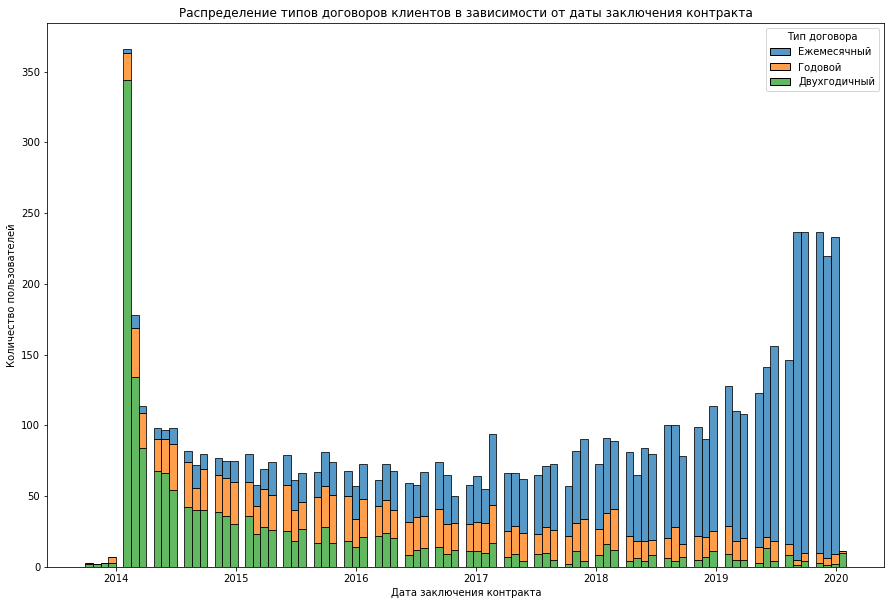

In [34]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot(data=contract_all,
            x='BeginDate',
            bins=100,
            hue='Type',
            multiple='stack')

plt.title('Распределение типов договоров клиентов в зависимости от даты заключения контракта')
plt.xlabel('Дата заключения контракта')
plt.ylabel('Количество пользователей')

legend = ax.get_legend()
handles = legend.legendHandles
legend.remove()
ax.legend(handles, ['Ежемесячный', 'Годовой', 'Двухгодичный'], title='Тип договора')

plt.show()

Из графика мы видим, что изначально клиенты чаще всего заключали двухгодичные контракты, постепенно их доля снижается, и на данный момент лидирующими являются ежемесячные контракты, а двухгодичные сводятся к  минимуму.

Доля годовых контрактов аналогично была значительно больше в 2014-2016 гг. 

Этот график еще раз подтверждает, что сейчас пользователи предпочитают месячные контракты, что позволяет им после окончания месяца прекратить договор.

In [35]:
contract_all.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,contract_duration,Group
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,...,No,Yes,No,No,No,No,no_used,0,31,3.0
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,0,No,...,Yes,No,Yes,No,No,No,No,0,1036,3.0
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,...,Yes,Yes,No,No,No,No,No,1,61,3.0
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,...,Yes,No,Yes,Yes,No,No,no_used,0,1371,3.0
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,...,No,No,No,No,No,No,No,1,61,1.0


## Анализ мультиколинеарности признаков

In [36]:
phik_overview = contract_all.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'target', 'contract_duration', 'Group']


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,contract_duration,Group
BeginDate,1.00,0.58,0.77,0.08,0.46,0.42,0.82,0.01,0.05,0.47,...,0.46,0.50,0.50,0.46,0.42,0.43,0.47,0.50,1.00,0.24
EndDate,0.58,1.00,0.36,0.16,0.21,0.32,0.25,0.00,0.12,0.12,...,0.31,0.26,0.25,0.31,0.21,0.21,0.04,1.00,0.41,0.24
Type,0.77,0.36,1.00,0.11,0.28,0.39,0.51,0.00,0.09,0.18,...,0.64,0.58,0.63,0.67,0.55,0.55,0.24,0.25,0.66,0.43
PaperlessBilling,0.08,0.16,0.11,1.00,0.37,0.47,0.21,0.00,0.24,0.01,...,0.21,0.20,0.20,0.20,0.20,0.20,0.10,0.30,0.00,0.21
PaymentMethod,0.46,0.21,0.28,0.37,1.00,0.40,0.35,0.00,0.29,0.24,...,0.32,0.29,0.30,0.32,0.28,0.29,0.17,0.45,0.38,0.29
MonthlyCharges,0.42,0.32,0.39,0.47,0.40,1.00,0.76,0.01,0.30,0.20,...,0.81,0.82,0.83,0.82,0.86,0.86,0.71,0.36,0.41,0.98
TotalCharges,0.82,0.25,0.51,0.21,0.35,0.76,1.00,0.00,0.15,0.42,...,0.53,0.57,0.57,0.54,0.57,0.57,0.49,0.28,0.84,0.54
gender,0.01,0.00,0.00,0.00,0.00,0.01,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SeniorCitizen,0.05,0.12,0.09,0.24,0.29,0.30,0.15,0.00,1.00,0.02,...,0.13,0.11,0.11,0.14,0.11,0.11,0.09,0.23,0.03,0.13
Partner,0.47,0.12,0.18,0.01,0.24,0.20,0.42,0.00,0.02,1.00,...,0.09,0.09,0.10,0.08,0.08,0.08,0.09,0.23,0.49,0.02


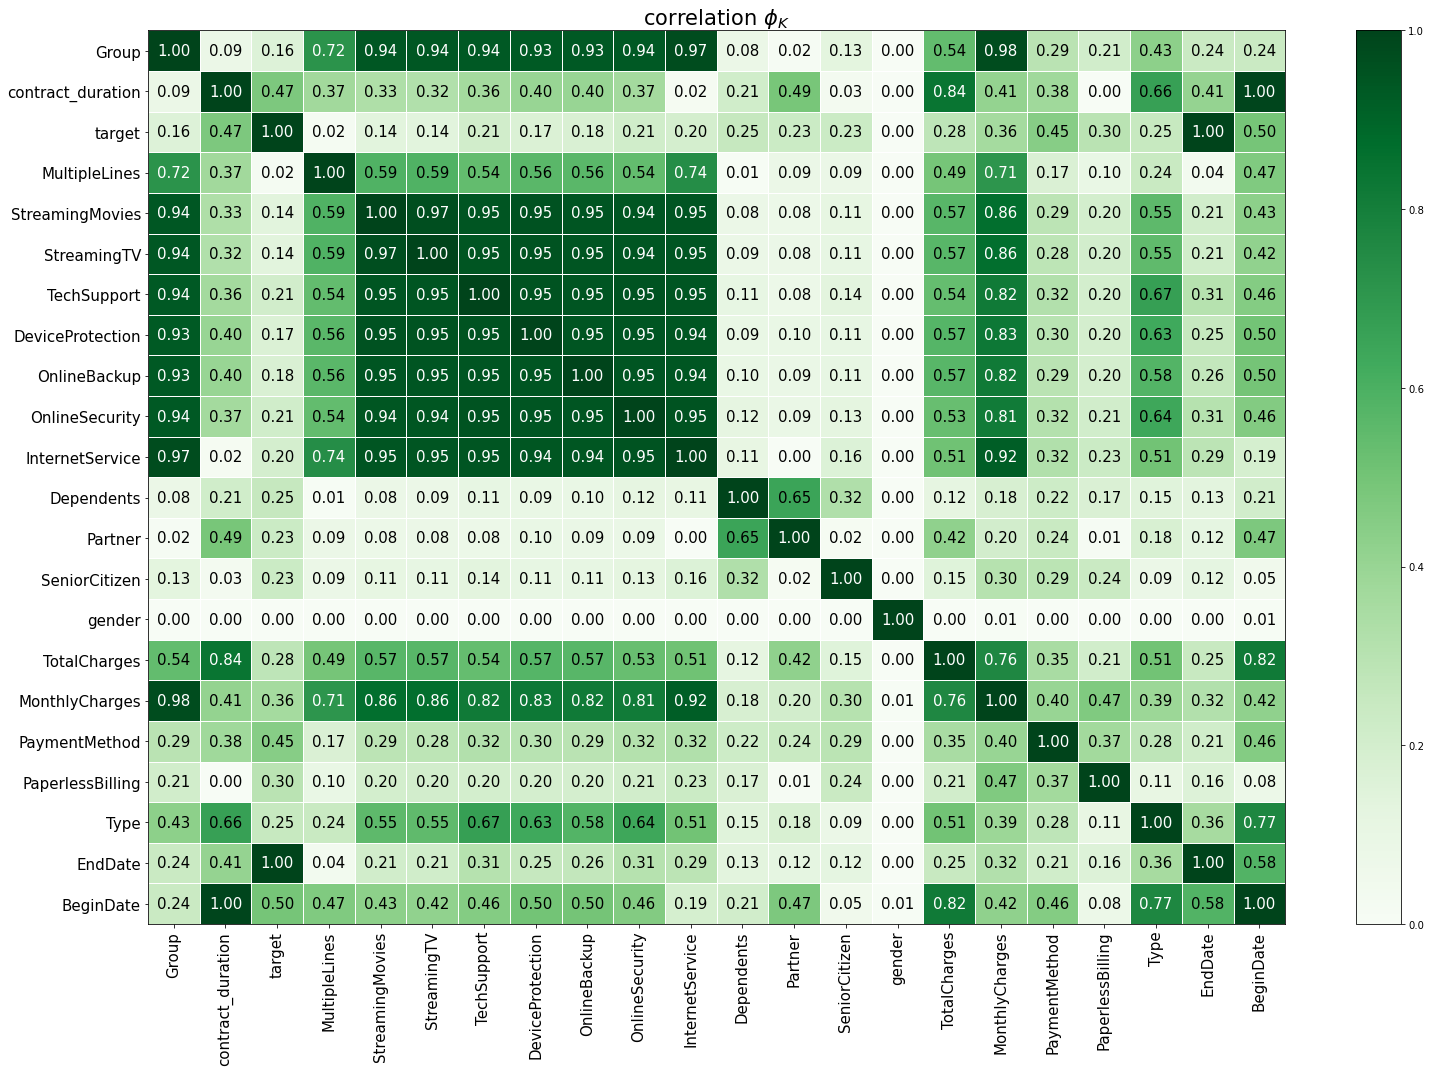

In [37]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(22, 15))
plt.tight_layout()

Мы видим, что существует некоторая корреляция между целевым признаком и такими переменными, как contract_duration, TotalCharges, MonthlyCharges, PaymentMethod, PaperlessBilling, Type. Признаки начала и окончания действия контракта мы не будем брать при обучении моделей, особенно EndDate, который напрямую предсказывает целевой признак.

Более того, мы видим, что совсем нет корреляции между целевым признаком и такими признаками, как MultipleLines и gender. Эти признаки нет смысла оставлять для обучения моделей.

Остальные признаки слабо коррелируют с целевым, но их мы оставим, потому что их влияние не сильное, но все же оно есть.

# Подготовка данных для обучения модели

## Подготовка признаков и целевого признака, выделение обучающей и тестовой выборок

Выделим отдельно категориальные признаки и количественные признаки. Признаки `BeginDate` и `EndDate` нам больше не требуются, мы получили из них всю необходимую информацию.

In [38]:
categorial_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'Partner', 'Dependents',
                      'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                      'StreamingTV', 'StreamingMovies', 'SeniorCitizen', 'Group']

numeric_features = ['MonthlyCharges', 'TotalCharges', 'contract_duration']

In [39]:
data = contract_all[numeric_features + categorial_features + ['target']]
data.head()

,MonthlyCharges,TotalCharges,contract_duration,Type,PaperlessBilling,PaymentMethod,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,SeniorCitizen,Group,target
customerID,,,,,,,,,,,,,,,,,,
7590-VHVEG,29.85,29.85,31,Month-to-month,Yes,Electronic check,Yes,No,DSL,No,Yes,No,No,No,No,0,3.0,0
5575-GNVDE,56.95,1889.50,1036,One year,No,Mailed check,No,No,DSL,Yes,No,Yes,No,No,No,0,3.0,0
3668-QPYBK,53.85,108.15,61,Month-to-month,Yes,Mailed check,No,No,DSL,Yes,Yes,No,No,No,No,0,3.0,1
7795-CFOCW,42.30,1840.75,1371,One year,No,Bank transfer (automatic),No,No,DSL,Yes,No,Yes,Yes,No,No,0,3.0,0
9237-HQITU,70.70,151.65,61,Month-to-month,Yes,Electronic check,No,No,Fiber optic,No,No,No,No,No,No,0,1.0,1


Выделим признаки и целевой признак.

In [40]:
target = data['target']
features = data.drop(['target'], axis=1)

print('Размер датасета с целевым признаком равен', target.shape)
print('Размер датасета со всеми признаками равен', features.shape)

Размер датасета с целевым признаком равен (7043,)
Размер датасета со всеми признаками равен (7043, 17)


## Деление выборки на обучающую и тестовую.

In [41]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25,
                                                                            random_state=311022, stratify=target)

features_train.shape, features_test.shape, target_train.shape, target_test.shape

((5282, 17), (1761, 17), (5282,), (1761,))

## Кодирование категориальных признаков

In [42]:
features_train = pd.get_dummies(features_train, drop_first=True)

In [43]:
features_test = pd.get_dummies(features_test, drop_first=True)

In [44]:
features_train.columns == features_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

# Обучение моделей, подбор гиперпараметров

## Модель Случайного леса

In [45]:
%%time

param = [{'n_estimators': range(1, 300, 50), 'max_depth':range(1, 10, 1)}]

model = RandomForestClassifier(random_state=311022, class_weight='balanced')
grid_search = GridSearchCV(model, param, cv=5, scoring='roc_auc')

grid_search.fit(features_train, target_train)

print('Лучшие параметры модели случайного леса:', grid_search.best_params_)
print('roc_auc модели случайного леса', grid_search.best_score_)

Лучшие параметры модели случайного леса: {'max_depth': 9, 'n_estimators': 201}
roc_auc модели случайного леса 0.8592776200346961
Wall time: 2min 34s


## Модель Логистической регрессии

In [46]:
std_slc = StandardScaler()
logistic_Reg = linear_model.LogisticRegression(random_state=311022)

In [47]:
pipe = Pipeline(steps=[('std_slc', std_slc),
                       ('logistic_Reg', logistic_Reg)])

In [48]:
n_components = list(range(1,features_train.shape[1]+1,1))
C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']

In [49]:
# Проверим список доступных параметров с помощью `estimator.get_params().keys()`.

logistic_Reg.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [50]:
%%time

parameters = dict(logistic_Reg__C=C,
                  logistic_Reg__penalty=penalty)

grid_search = GridSearchCV(pipe,
                           parameters,
                           scoring='roc_auc',
                           cv=5,
                           verbose=1)

grid_search.fit(features_train, target_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

Wall time: 16 s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.8275045         nan 0.82904569        nan 0.83057137
        nan 0.83232184        nan 0.83404576        nan 0.83562787
        nan 0.8370231         nan 0.83825608        nan 0.83940301
        nan 0.84050839        nan 0.84135625        nan 0.8419821
        nan 0.84265357        nan 0.84320955        nan 0.84362023
        nan 0.84411082        nan 0.84447094        nan 0.84494595
        nan 0.84522345        nan 0.84559392        nan 0.84579811
        nan 0.84599218        nan 0.84612085        nan 0.84619436
        nan 0.84629534        nan 0.84639824        nan 0.84643415
        nan 0.84645343        nan 0.84647821        nan 0.84648097
        nan 0.84649199        nan 0.84649014        nan 0.84650578
        nan 0.84650761        nan 0.84649658        nan 0.8465067
        nan 0.84650854        nan 0.8465067         nan

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std_slc', StandardScaler()),
                                       ('logistic_Reg',
                                        LogisticRegression(random_state=311022))]),
             param_grid={'logistic_Reg__C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9...
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                         'logistic_Reg__penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1

In [51]:
print('Лучшие параметры модели Логистической регрессии:', grid_search.best_params_)
print('roc_auc модели Логистической регрессии', grid_search.best_score_)

Лучшие параметры модели Логистической регрессии: {'logistic_Reg__C': 75.43120063354607, 'logistic_Reg__penalty': 'l2'}
roc_auc модели Логистической регрессии 0.8465085377805963


## Модель LightGBM

In [52]:
%%time

model = LGBMClassifier(random_state=311022, class_weight='balanced')

param = [{'n_estimators': range(1, 600, 100), 'max_depth':range(1, 7, 1), 'learning_rate': [0.1]}]

grid_search = GridSearchCV(model, param_grid=param, scoring='roc_auc', cv=5, verbose=True)
grid_search.fit(features_train, target_train)

print('Лучшие параметры модели LightGBM:', grid_search.best_params_)
print('roc_auc модели LightGBM', grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Лучшие параметры модели LightGBM: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 501}
roc_auc модели LightGBM 0.9030916714055106
Wall time: 27.7 s


## Модель CatBoost

In [53]:
one_class = data.loc[data['target'] == 1].shape[0] / data['target'].shape[0]
zero_class = 1 - one_class
class_weights = [one_class, zero_class]
class_weights

[0.2653698707936959, 0.7346301292063041]

In [54]:
%%time

model = CatBoostClassifier(random_state=31022, silent=True, class_weights=class_weights)

param = [{'max_depth': range(1, 10, 1),
               'learning_rate': [0.001],
               'n_estimators': range(70, 75, 100)}]

grid_search = GridSearchCV(model, param_grid=param, scoring='roc_auc', cv=3, verbose=True, n_jobs=-1)
grid_search.fit(features_train, target_train)

grid_search.best_params_, grid_search.best_score_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Wall time: 10 s


({'learning_rate': 0.001, 'max_depth': 9, 'n_estimators': 70},
 0.8492955012890393)

Таким образом, наибольшее значение метрики качества:

- AUC_ROC = 0.9030916714055106 показала модель градиентного бустинга, библиотека LightGBM: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 501}

Проверим полученную модель на тестовой выборке.

# Тестирование лучшей модели на тестовой выборке

In [55]:
model = LGBMClassifier(random_state=311022, class_weight='balanced', learning_rate = 0.1, max_depth = 4, n_estimators = 501)

param = [{'n_estimators': range(1, 600, 100), 'max_depth':range(1, 7, 1), 'learning_rate': [0.1]}]

model.fit(features_train, target_train)
prediction = model.predict_proba(features_test)[:,1]

auc_roc_LGBM = roc_auc_score(target_test, prediction)

print('auc_roc модели LightGBM, на тестовой выборке', auc_roc_LGBM)

auc_roc модели LightGBM, на тестовой выборке 0.9055101953009939


Проделанная нами работа в проекте позволила создать и подобрать модель для предсказания оттока клиентов для оператора связи «Ниединогоразрыва.ком». Значение метрики качества получилось на тестовой выборке равным 0.9055, это больше, чем минимальное значение по условиям проекта. Цель достигнута!

# Отчет по проекту

В данном проекте перед нами стояла задача создания и настройки модели для прогнозирования оттока клиентов оператора связи «Ниединогоразрыва.ком». Изначально был разработан примерный план решения поставленной задачи. Нам удалось придерживаться намеченного плана в процессе работы, мы шли последовательно по всем пунктам. Единственное, что можно отметить, мы не нашли аномальных значений в признаках, поэтому никакие объекты-строки из данных не пришлось удалять.

В изначальном плане мы не прописывали заранее способ объединения исходных данных, решение об способе объединения таблиц принимали после подробного анализа признаков и таблиц.

Также в изначальном плане мы заранее не указывали модели, которые будем обучать и настраивать. Их добавляли по очереди уже в процессе выполнения проекта. И когда достигли необходимого качества модели на обучающей выборке, то перешли непосредственно к проверке лучшей модели на тестовой выборке.

Настройка моделей была успешной по причине того, что мы предварительно провели качественный исследовательский анализ признаков, добавили дополнительные признаки и убрали явные лишние признаки. Кроме этого мы провели анализ мультиколинеарности признаков, на основе которого мы удалили 2 признака, которые совсем не коррелируют в целевым признаком: MultipleLines и gender.

Проект был выполнен по следующим этапам:

1. Первоначальный исследовательский анализ исходных данных. Формирование примерного плана решения задачи проекта.
    
2. Проведение предобработки исходных данных:
        - проверили, что нет дубликатов, которые необходимо удалять.
        - заменили тип значений в столбце `TotalCharges` на вещественный, предварительно обработали пробелы в этом столбце, заменив на 0.
        - проверили, что нет аномальных значений в признаках.
        
        В результате этого не удаляли никакие строки с данными.
        
3. Объединение исходных 4 таблиц с данными в одну общую методом `left`, путем последовательного присоединения к таблице `contract` остальных таблиц. Образовавшиеся после объединения пропуски заполнили значениями 'no_used'. Объединение производили по индексам `customerID`.
    
4. Работа непосредственно с самими признаками:
        - определили целевой признак на основе столбца `EndDate`, то есть создали новый столбец `target`, в котором 1 означает, что клиент расторгнул договор, а 0 - означает, что договор с клиентом действующий. Оценили дисбаланс классов.
        - создали новый признак с длительностью контракта в днях `contract_duration`, путем нахождения разницы между столбцами `EndDate` и `BeginDate`.
        - создали новый признак с группировкой клиентов по объему их ежемесячных расходов `Group` (1 группа - расходы от 68 до 107; 2 группа - расходы меньше 27; 3 группа - все остальные клиенты).
        - провели анализ "Распределения общей суммы трат на услуги" на основании столбца `TotalCharges`.
        - провели анализ "Распределения типов договоров клиентов в зависимости от даты заключения контракта" на основании столбцов `BeginDate` и `Type`.
        - провели анализ мультиколинеарности признаков, в результате которого приняли решение об исключении признаков `MultipleLines` и `gender` из дальнейнего обучения моделей.
        
5. Подготовка данных для обучения моделей:
        - разделили признаки на категориальные и количественные. При этом исключили признаки `MultipleLines` и `gender`, а также `EndDate` и `BeginDate`.
        - разделили выборку на обучающую и тестовую с соотношении 75% на 25%.
        - провели кодирование категориальных признаков техникой прямого кодирования (get_dummies).
        
6. Создание моделей, подбор гиперпараметров с помощью кросс-валидации и настройка этих моделей. Рассмотрели следующие модели:
        - модель Случайного леса
        - модель Логистической регрессии
        - модель LightGBM
        - модель CatBoost
    
7. Заключительным этапом стала проверка лучшей модели с подобранными гиперпараметрами на тестовой выборке.

В результате проделанной работы **лучшей оказалась модель градиентного бустинга, библиотека LightGBM** (с такими гиперпараметрами: learning_rate = 0.1, max_depth = 4, n_estimators = 501), у нее на тестовой выборке получили метрику качества auc_roc = 0.9055101953009939.